In [2]:
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys

import argparse, os, math, pickle, json

# 1) Load your model
from dual_alm_rnn_models import *
from dual_alm_rnn_exp import DualALMRNNExp



Get the readout accuracies per side

one seed:


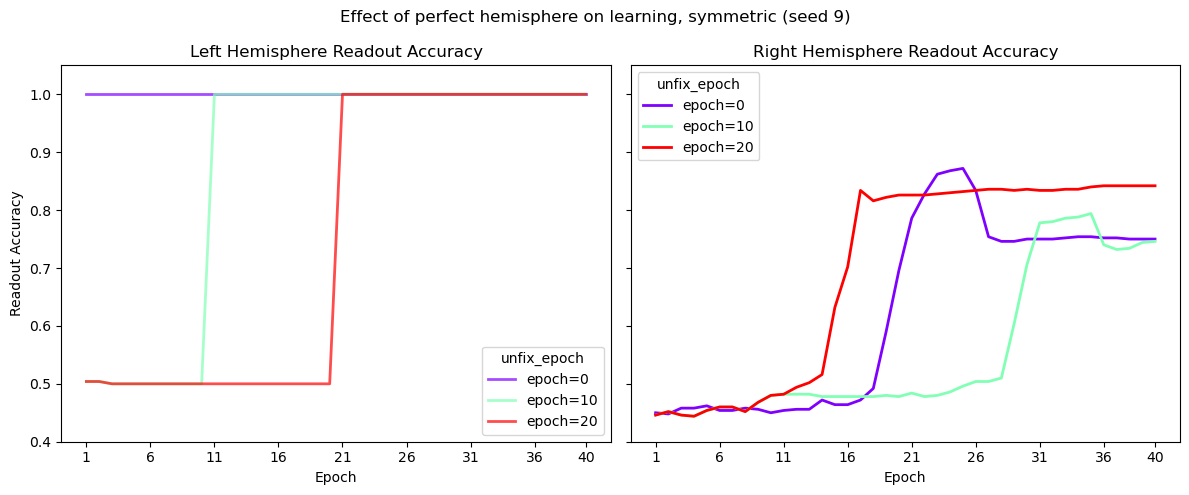

In [42]:
exp = DualALMRNNExp()
all_readout_acc_right = []
all_readout_acc_left = []
unfix_epochs = [0, 10, 20, 30]
unfix_epochs = [0,'0_sherlock',20] # local vs sherlock
unfix_epochs
random_seed = 9
unfix_epochs = [0,10,20]
# unfix_epochs = ['11._1p5', '11']

# For color mapping: use a colormap for right hemisphere lines
import matplotlib
cmap = plt.get_cmap('Blues')
cmap = plt.get_cmap('rainbow')
colors = [cmap(i/(len(unfix_epochs)-1)) for i in range(len(unfix_epochs))]

for unfix_epoch in unfix_epochs:
    if 'asymmetric_fix' in exp.configs['train_type']:
        results_dict = np.load(
            'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/unfix_epoch_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
                exp.configs['model_type'],
                "train_type_asymmetric_fixed_input_double_readout",
                # exp.configs['random_seed'],
                random_seed,
                unfix_epoch,
                float(exp.configs['xs_left_alm_amp']),
                float(exp.configs['xs_right_alm_amp'])),
            allow_pickle=True
        )

    epochs = np.arange(1, len(results_dict) + 1)
    readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
    readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

    all_readout_acc_left.append(readout_acc_left)
    all_readout_acc_right.append(readout_acc_right)

# Set xticks every 5 epochs (e.g., 1, 5, 10, 15, ...)
max_epoch = epochs[-1]
xticks = np.arange(1, max_epoch+1, 5)
if xticks[-1] != max_epoch:
    xticks = np.append(xticks, max_epoch)

# Plot: two subplots, left and right hemisphere accuracy, right with color/legend for unfix_epoch
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Left hemisphere subplot
for i, unfix_epoch in enumerate(unfix_epochs):
    label = f'epoch={unfix_epoch}'
    ax_left.plot(epochs, all_readout_acc_left[i], color=colors[i], label=label, alpha=0.7, linewidth=2)
ax_left.set_title('Left Hemisphere Readout Accuracy')
ax_left.set_xlabel('Epoch')
ax_left.set_ylabel('Readout Accuracy')
ax_left.set_xticks(xticks)
ax_left.set_ylim(0.4, 1.05)
ax_left.legend(title='unfix_epoch', loc='lower right')

# Right hemisphere subplot
for i, unfix_epoch in enumerate(unfix_epochs):
    label = f'epoch={unfix_epoch}'
    ax_right.plot(epochs, all_readout_acc_right[i], color=colors[i], label=label, linewidth=2)
ax_right.set_title('Right Hemisphere Readout Accuracy')
ax_right.set_xlabel('Epoch')
ax_right.set_xticks(xticks)
ax_right.set_ylim(0.4, 1.05)
ax_right.legend(title='unfix_epoch', loc='upper left')
plt.suptitle('Effect of perfect hemisphere on learning, symmetric (seed {})'.format(random_seed))
plt.tight_layout()
plt.show()

All seeds as subplots

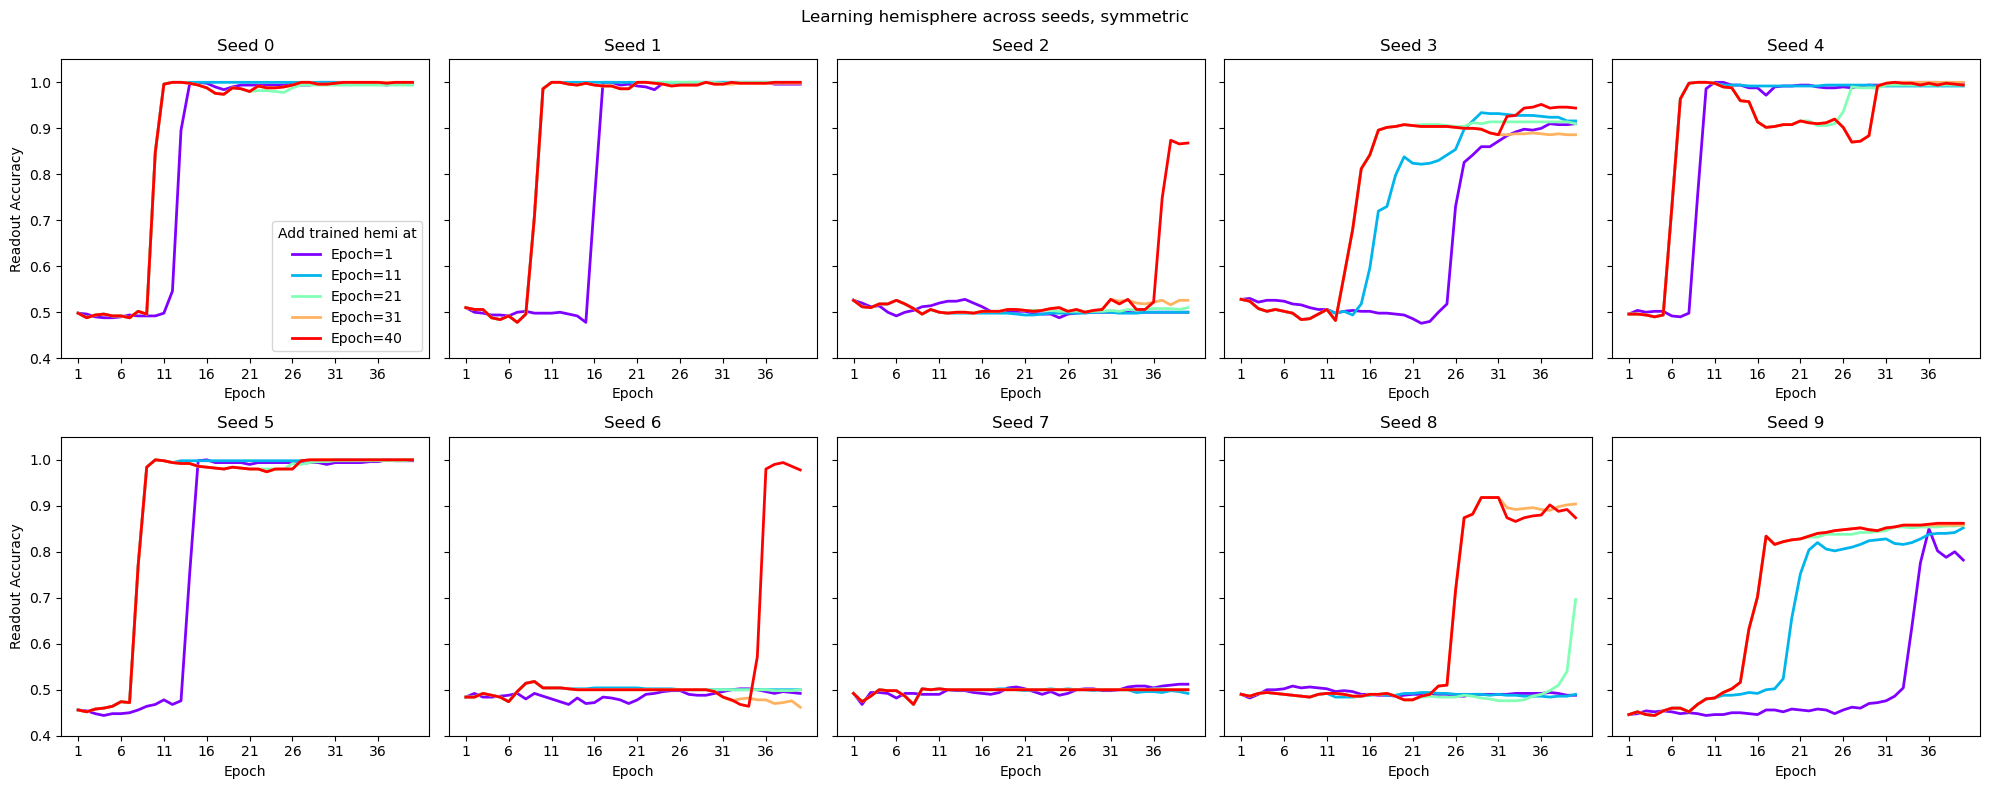

In [22]:
# Iterate over all 10 random seeds and plot overlays per unfix_epoch regime

unfix_epochs = [0, 10, 20, 30, 40]
# unfix_epochs = [0,20,40]
unfix_epochs = [1,11,21,31,40]

num_seeds = 10

import matplotlib
# Use a rainbow colormap for each unfix_epoch
cmap = plt.get_cmap('rainbow')
colors = [cmap(i/(len(unfix_epochs)-1)) for i in range(len(unfix_epochs))]

# Store all runs for plotting
all_readout_acc_left = [[]
                        for _ in range(len(unfix_epochs))]
all_readout_acc_right = [[]
                         for _ in range(len(unfix_epochs))]

for seed in range(num_seeds):
    exp = DualALMRNNExp()
    exp.configs['random_seed'] = seed  # override seed for this run

    for i, unfix_epoch in enumerate(unfix_epochs):
        if 'asymmetric_fix' in exp.configs['train_type']:
            results_dict = np.load(
                'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/unfix_epoch_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
                    exp.configs['model_type'],
                    "train_type_asymmetric_fixed_input",
                    seed,
                    unfix_epoch,
                    float(exp.configs['xs_left_alm_amp']),
                    float(exp.configs['xs_right_alm_amp'])),
                allow_pickle=True
            )

        epochs = np.arange(1, len(results_dict) + 1)
        readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
        readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

        all_readout_acc_left[i].append(readout_acc_left)
        all_readout_acc_right[i].append(readout_acc_right)

# Plot: 10 subplots (2 rows x 5 columns), one for each seed, plotting right hemisphere readout accuracy for all unfix_epochs
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
axes = axes.flatten()

for seed in range(num_seeds):
    ax = axes[seed]
    for i, unfix_epoch in enumerate(unfix_epochs):
        # Plot right hemisphere accuracy for this seed and unfix_epoch
        ax.plot(epochs, all_readout_acc_right[i][seed], color=colors[i], label=f'unfix_epoch={unfix_epoch}' if seed == 0 else None, linewidth=2)
    ax.set_title(f'Seed {seed}')
    ax.set_xlabel('Epoch')
    if seed % 5 == 0:
        ax.set_ylabel('Readout Accuracy')
    ax.set_xticks(epochs[::5])
    ax.set_ylim(0.4, 1.05)

# Only add legend to the first subplot
handles = [matplotlib.lines.Line2D([0], [0], color=colors[i], lw=2) for i in range(len(unfix_epochs))]
labels = [f'Epoch={unfix_epochs[i]}' for i in range(len(unfix_epochs))]
axes[0].legend(handles, labels, title='Add trained hemi at', loc='lower right')

plt.suptitle('Learning hemisphere across seeds, symmetric')
plt.tight_layout()
plt.show()

All seeds overlay:


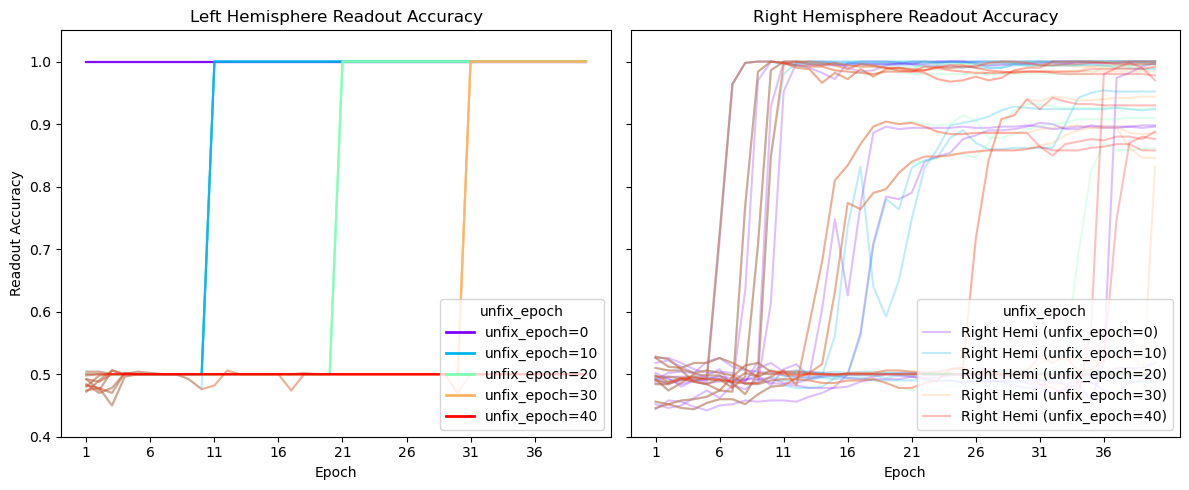

In [8]:
# Iterate over all 10 random seeds and plot overlays per unfix_epoch regime

unfix_epochs = [0, 10, 20, 30, 40]
num_seeds = 10

import matplotlib
# Use a rainbow colormap for each unfix_epoch
cmap = plt.get_cmap('rainbow')
colors = [cmap(i/(len(unfix_epochs)-1)) for i in range(len(unfix_epochs))]

# Store all runs for plotting
all_readout_acc_left = [[]
                        for _ in range(len(unfix_epochs))]
all_readout_acc_right = [[]
                         for _ in range(len(unfix_epochs))]

for seed in range(num_seeds):
    exp = DualALMRNNExp()
    exp.configs['random_seed'] = seed  # override seed for this run

    for i, unfix_epoch in enumerate(unfix_epochs):
        if 'asymmetric_fix' in exp.configs['train_type']:
            results_dict = np.load(
                'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/unfix_epoch_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
                    exp.configs['model_type'],
                    exp.configs['train_type'],
                    seed,
                    unfix_epoch,
                    float(exp.configs['xs_left_alm_amp']),
                    float(exp.configs['xs_right_alm_amp'])),
                allow_pickle=True
            )

        epochs = np.arange(1, len(results_dict) + 1)
        readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
        readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

        all_readout_acc_left[i].append(readout_acc_left)
        all_readout_acc_right[i].append(readout_acc_right)

# Plot: two subplots, left and right hemisphere accuracy, overlaying all 10 runs per unfix_epoch
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Left hemisphere subplot: overlay all seeds for each unfix_epoch, color-coded by unfix_epoch (rainbow)
for i, unfix_epoch in enumerate(unfix_epochs):
    for run in range(num_seeds):
        ax_left.plot(epochs, all_readout_acc_left[i][run], color=colors[i], alpha=0.25)
ax_left.set_title('Left Hemisphere Readout Accuracy')
ax_left.set_xlabel('Epoch')
ax_left.set_ylabel('Readout Accuracy')
ax_left.set_xticks(epochs[::5])
ax_left.set_ylim(0.4, 1.05)
# Add legend for each unfix_epoch (rainbow colors)
handles_left = [matplotlib.lines.Line2D([0], [0], color=colors[i], lw=2) for i in range(len(unfix_epochs))]
labels_left = [f'unfix_epoch={unfix_epochs[i]}' for i in range(len(unfix_epochs))]
ax_left.legend(handles_left, labels_left, title='unfix_epoch', loc='lower right')

# Right hemisphere subplot: overlay all seeds for each unfix_epoch, color-coded by unfix_epoch (rainbow)
for i, unfix_epoch in enumerate(unfix_epochs):
    for run in range(num_seeds):
        label = f'Right Hemi (unfix_epoch={unfix_epoch})' if run == 0 else None
        ax_right.plot(epochs, all_readout_acc_right[i][run], color=colors[i], alpha=0.25, label=label)
# Add legend only once per unfix_epoch
handles, labels = ax_right.get_legend_handles_labels()
unique_labels = []
unique_handles = []
for h, l in zip(handles, labels):
    if l not in unique_labels and l is not None:
        unique_labels.append(l)
        unique_handles.append(h)
ax_right.set_title('Right Hemisphere Readout Accuracy')
ax_right.set_xlabel('Epoch')
ax_right.set_xticks(epochs[::5])
ax_right.set_ylim(0.4, 1.05)
ax_right.legend(unique_handles, unique_labels, title='unfix_epoch', loc='lower right')

plt.tight_layout()
plt.show()

Analyze over different asymmetries

Single seed:


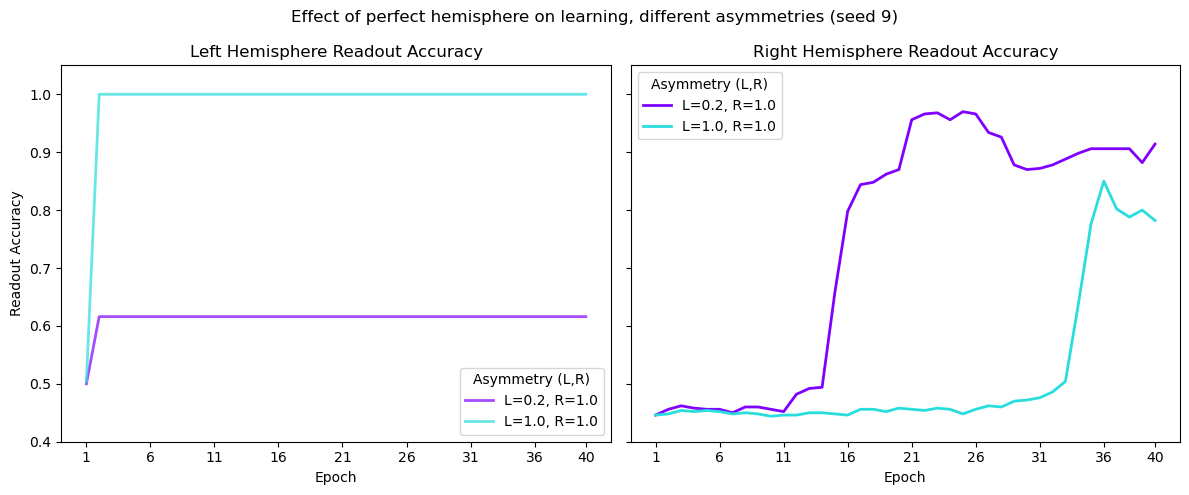

In [23]:
exp = DualALMRNNExp()
all_readout_acc_right = []
all_readout_acc_left = []
unfix_epochs = [0, 10, 20, 30, 40]

random_seed = 9
unfix_epochs = [1,11,21,40]
unfix_epoch = 1
asymmetries = [(0.2,1.0),(1.0,1.0)]

# For color mapping: use a colormap for right hemisphere lines

cmap = plt.get_cmap('Blues')
cmap = plt.get_cmap('rainbow')
colors = [cmap(i/(len(unfix_epochs)-1)) for i in range(len(unfix_epochs))]

# Iterate over asymmetries instead of unfix_epochs
all_readout_acc_right = []
all_readout_acc_left = []
asymmetry_labels = []
for i, (left_alm_amp, right_alm_amp) in enumerate(asymmetries):
    if 'asymmetric_fix' in exp.configs['train_type']:
        results_dict = np.load(
            'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/unfix_epoch_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
                exp.configs['model_type'],
                "train_type_asymmetric_fixed_input",
                # exp.configs['random_seed'],
                random_seed,
                unfix_epoch,
                left_alm_amp,
                right_alm_amp),
            allow_pickle=True
        )

    epochs = np.arange(1, len(results_dict) + 1)
    readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
    readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

    all_readout_acc_left.append(readout_acc_left)
    all_readout_acc_right.append(readout_acc_right)
    asymmetry_labels.append(f"L={left_alm_amp:.1f}, R={right_alm_amp:.1f}")

# Set xticks every 5 epochs (e.g., 1, 5, 10, 15, ...)
max_epoch = epochs[-1]
xticks = np.arange(1, max_epoch+1, 5)
if xticks[-1] != max_epoch:
    xticks = np.append(xticks, max_epoch)

# Plot: two subplots, left and right hemisphere accuracy, colored/legend by asymmetry
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Left hemisphere subplot
for i, label in enumerate(asymmetry_labels):
    ax_left.plot(epochs, all_readout_acc_left[i], color=colors[i], label=label, alpha=0.7, linewidth=2)
ax_left.set_title('Left Hemisphere Readout Accuracy')
ax_left.set_xlabel('Epoch')
ax_left.set_ylabel('Readout Accuracy')
ax_left.set_xticks(xticks)
ax_left.set_ylim(0.4, 1.05)
ax_left.legend(title='Asymmetry (L,R)', loc='lower right')

# Right hemisphere subplot
for i, label in enumerate(asymmetry_labels):
    ax_right.plot(epochs, all_readout_acc_right[i], color=colors[i], label=label, linewidth=2)
ax_right.set_title('Right Hemisphere Readout Accuracy')
ax_right.set_xlabel('Epoch')
ax_right.set_xticks(xticks)
ax_right.set_ylim(0.4, 1.05)
ax_right.legend(title='Asymmetry (L,R)', loc='upper left')
plt.suptitle('Effect of perfect hemisphere on learning, different asymmetries (seed {})'.format(random_seed))

plt.tight_layout()
plt.show()

Over all seeds:

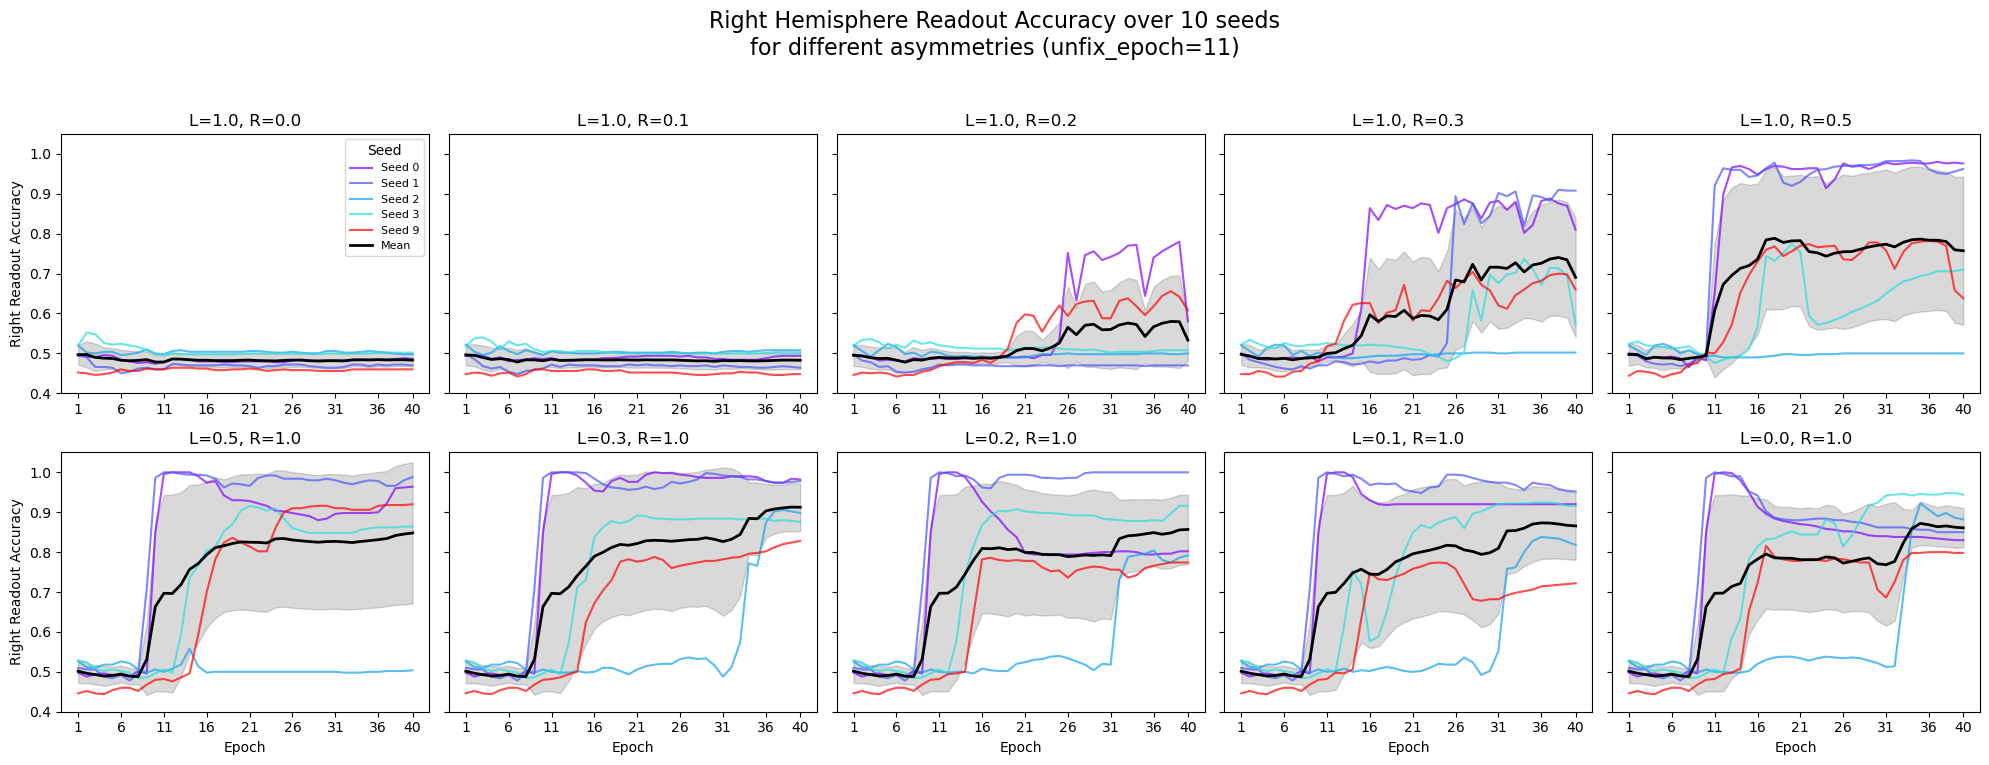

In [31]:
exp = DualALMRNNExp()
all_readout_acc_right = []
all_readout_acc_left = []
unfix_epochs = [0, 10, 20, 30, 40]
unfix_epochs = [1,11,21,31,40]
# Plot over all 10 seeds for a range of asymmetries (unfix_epoch constant) as 10 subplots (2 rows, 5 columns)

unfix_epoch = 11  # keep constant
asymmetries = [
    (0.2, 1.0), (0.4, 1.0), (0.6, 1.0), (0.8, 1.0), (1.0, 1.0),
    (1.0, 0.8), (1.0, 0.6), (1.0, 0.4), (1.0, 0.2), (0.5, 0.5)
]
# asymmetries = [(0.2,1.0),(1.0,1.0)]

asymmetries = [(1.0,0.0), (1.0,0.1), (1.0,0.2), (1.0,0.3), #(1.0,0.4), 
                (1.0,0.5), (0.5,1.0),  (0.3,1.0), (0.2,1.0), (0.1,1.0), (0.0,1.0)
                ]

n_seeds = 10
seeds = list(range(n_seeds))

# For color mapping: use a colormap for seeds
cmap = plt.get_cmap('rainbow')
colors = [cmap(i/(n_seeds-1)) for i in range(n_seeds)]

fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
axes = axes.flatten()

# For storing mean accuracy for (1.0, 1.0) case
mean_acc_1_1 = None
epochs_1_1 = None

for idx, (left_alm_amp, right_alm_amp) in enumerate(asymmetries):
    ax = axes[idx]
    all_readout_acc_left = []
    all_readout_acc_right = []
    for s, random_seed in enumerate(seeds):
        try:
            results_dict = np.load(
                'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/unfix_epoch_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
                    exp.configs['model_type'],
                    "train_type_asymmetric_fixed_input",
                    random_seed,
                    unfix_epoch,
                    left_alm_amp,
                    right_alm_amp),
                allow_pickle=True
            )
        except FileNotFoundError:
            # If missing, skip this seed
            continue

        epochs = np.arange(1, len(results_dict) + 1)
        readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
        readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])
        all_readout_acc_left.append(readout_acc_left)
        all_readout_acc_right.append(readout_acc_right)

        # Plot each seed's right hemisphere accuracy
        ax.plot(epochs, readout_acc_right, color=colors[s], alpha=0.7, linewidth=1.5, label=f"Seed {s}" if idx==0 else None)

    # Optionally, plot mean and std across seeds
    if all_readout_acc_right:
        arr = np.stack(all_readout_acc_right)
        mean_acc = arr.mean(axis=0)
        std_acc = arr.std(axis=0)
        ax.plot(epochs, mean_acc, color='black', linewidth=2, label='Mean')
        ax.fill_between(epochs, mean_acc-std_acc, mean_acc+std_acc, color='black', alpha=0.15)
        # Save mean and epochs for (1.0, 1.0) case
        if np.isclose(left_alm_amp, 1.0) and np.isclose(right_alm_amp, 1.0):
            mean_acc_1_1 = mean_acc
            epochs_1_1 = epochs

    # Set xticks every 5 epochs
    max_epoch = epochs[-1]
    xticks = np.arange(1, max_epoch+1, 5)
    if xticks[-1] != max_epoch:
        xticks = np.append(xticks, max_epoch)
    ax.set_xticks(xticks)
    ax.set_ylim(0.4, 1.05)
    ax.set_title(f"L={left_alm_amp:.1f}, R={right_alm_amp:.1f}")
    if idx % 5 == 0:
        ax.set_ylabel('Right Readout Accuracy')
    if idx >= 5:
        ax.set_xlabel('Epoch')
    if idx == 0:
        ax.legend(loc='upper right', fontsize=8, title='Seed')

# Plot the mean readout accuracy for the (1.0, 1.0) case across seeds on all subplots for reference
if mean_acc_1_1 is not None and epochs_1_1 is not None:
    for ax in axes:
        ax.plot(epochs_1_1, mean_acc_1_1, color='magenta', linewidth=2, linestyle='--', label='Mean (L=1.0, R=1.0)')
    # Add legend to the first subplot if not already present
    handles, labels = axes[0].get_legend_handles_labels()
    if 'Mean (L=1.0, R=1.0)' not in labels:
        axes[0].legend(loc='upper right', fontsize=8, title='Seed')

plt.suptitle('Right Hemisphere Readout Accuracy over 10 seeds\nfor different asymmetries (unfix_epoch={})'.format(unfix_epoch), fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

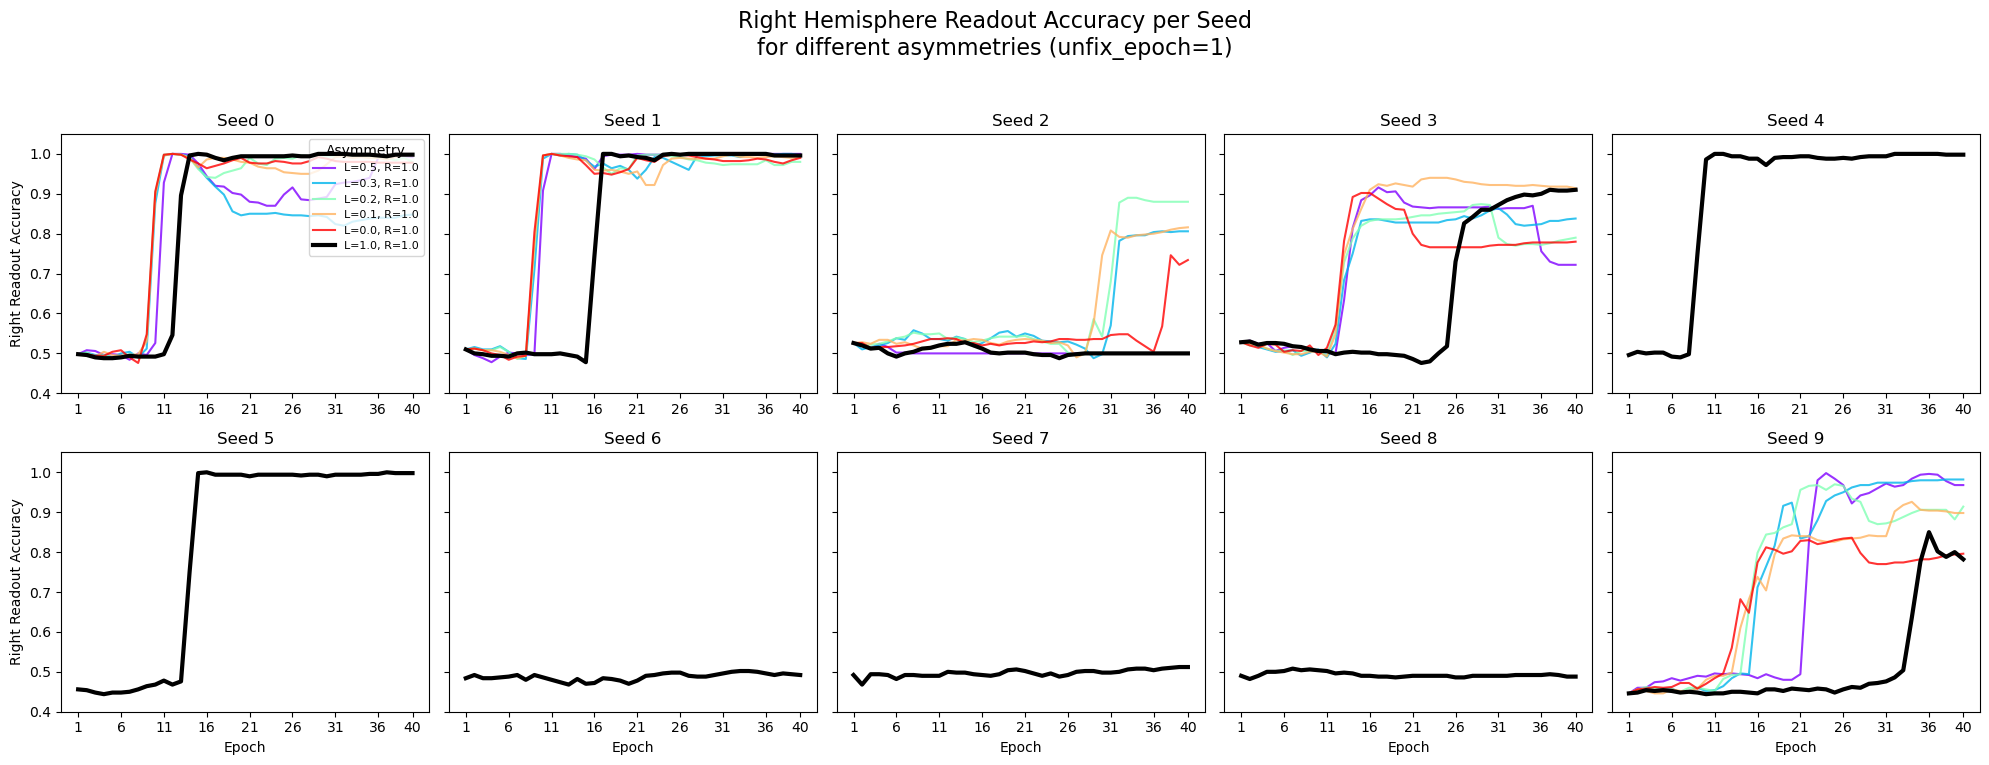

In [60]:
exp = DualALMRNNExp()
all_readout_acc_right = []
all_readout_acc_left = []
unfix_epochs = [0, 10, 20, 30, 40]
unfix_epochs = [1,11,21,31,40]
# Plot over all 10 seeds for a range of asymmetries (unfix_epoch constant) as 10 subplots (2 rows, 5 columns)

unfix_epoch = 1 # keep constant
asymmetries = [
    (0.2, 1.0), (0.4, 1.0), (0.6, 1.0), (0.8, 1.0), (1.0, 1.0),
    (1.0, 0.8), (1.0, 0.6), (1.0, 0.4), (1.0, 0.2), (0.5, 0.5)
]
# asymmetries = [(0.2,1.0),(1.0,1.0)]

asymmetries = [(1.0,0.0), (1.0,0.1), (1.0,0.2), (1.0,0.3), (1.0,0.5)]#, (0.5,1.0), (0.3,1.0), (0.2,1.0), (0.1,1.0), (0.0,1.0)]
asymmetries = [(0.5,1.0), (0.3,1.0), (0.2,1.0), (0.1,1.0), (0.0,1.0)]
n_seeds = 10
seeds = list(range(n_seeds))

# For color mapping: use a colormap for asymmetries
cmap = plt.get_cmap('rainbow')
colors = [cmap(i/(len(asymmetries)-1)) for i in range(len(asymmetries))]

fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
axes = axes.flatten()

# Preload all results for (1.0, 1.0) for all seeds
acc_1_1_per_seed = {}
epochs_1_1 = None
for s, random_seed in enumerate(seeds):
    try:
        results_dict_1_1 = np.load(
            'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/unfix_epoch_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
                exp.configs['model_type'],
                "train_type_asymmetric_fixed_input",
                random_seed,
                unfix_epoch,
                1.0,
                1.0),
            allow_pickle=True
        )
        epochs = np.arange(1, len(results_dict_1_1) + 1)
        readout_acc_right_1_1 = np.array([results_dict_1_1[i]['control']['readout_accuracy_right'] for i in range(len(results_dict_1_1))])
        acc_1_1_per_seed[s] = (epochs, readout_acc_right_1_1)
        if epochs_1_1 is None:
            epochs_1_1 = epochs
    except FileNotFoundError:
        acc_1_1_per_seed[s] = None

# Now, for each seed, plot all asymmetries as colored lines, and the 1.0:1.0 as a thick black line
for idx, random_seed in enumerate(seeds):
    ax = axes[idx]
    for a_idx, (left_alm_amp, right_alm_amp) in enumerate(asymmetries):
        try:
            results_dict = np.load(
                'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/unfix_epoch_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
                    exp.configs['model_type'],
                    "train_type_asymmetric_fixed_input",
                    random_seed,
                    unfix_epoch,
                    left_alm_amp,
                    right_alm_amp),
                allow_pickle=True
            )
        except FileNotFoundError:
            continue

        epochs = np.arange(1, len(results_dict) + 1)
        readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])
        label = f"L={left_alm_amp:.1f}, R={right_alm_amp:.1f}"
        ax.plot(epochs, readout_acc_right, color=colors[a_idx], alpha=0.8, linewidth=1.5, label=label if idx==0 else None)

    # Plot the 1.0:1.0 case for this seed as a thick black line
    if acc_1_1_per_seed[idx] is not None:
        epochs_1_1, acc_1_1 = acc_1_1_per_seed[idx]
        ax.plot(epochs_1_1, acc_1_1, color='black', linewidth=3, label='L=1.0, R=1.0' if idx==0 else None, zorder=10)

    # Set xticks every 5 epochs
    if epochs_1_1 is not None:
        max_epoch = epochs_1_1[-1]
        xticks = np.arange(1, max_epoch+1, 5)
        if xticks[-1] != max_epoch:
            xticks = np.append(xticks, max_epoch)
        ax.set_xticks(xticks)
    ax.set_ylim(0.4, 1.05)
    ax.set_title(f"Seed {random_seed}")
    if idx % 5 == 0:
        ax.set_ylabel('Right Readout Accuracy')
    if idx >= 5:
        ax.set_xlabel('Epoch')
    if idx == 0:
        # Show legend only on first subplot
        ax.legend(loc='upper right', fontsize=8, title='Asymmetry')

plt.suptitle('Right Hemisphere Readout Accuracy per Seed\nfor different asymmetries (unfix_epoch={})'.format(unfix_epoch), fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

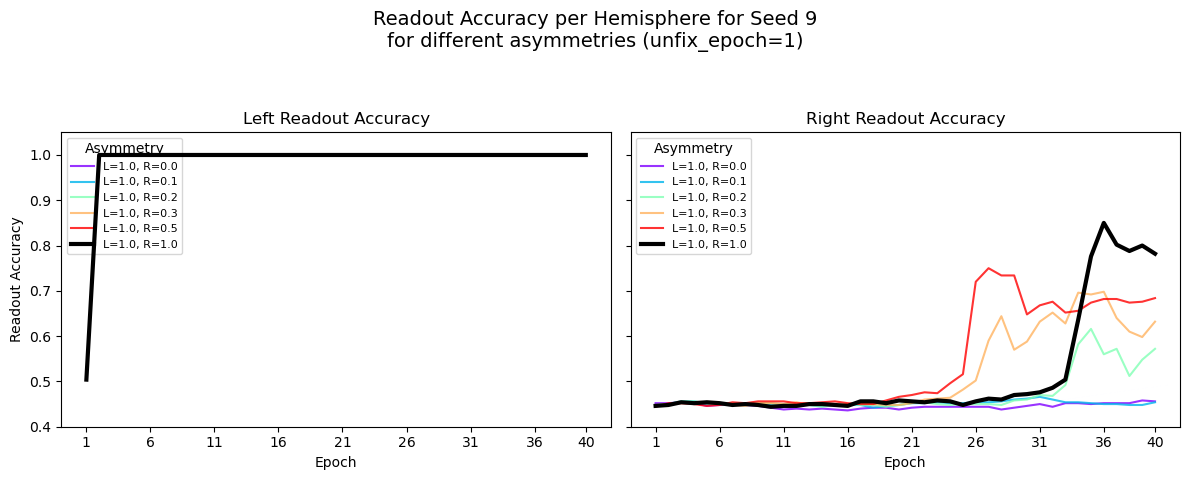

In [65]:
exp = DualALMRNNExp()
all_readout_acc_right = []
all_readout_acc_left = []
unfix_epochs = [0, 10, 20, 30, 40]
unfix_epochs = [1,11,21,31,40]
# Plot over all 10 seeds for a range of asymmetries (unfix_epoch constant) as 10 subplots (2 rows, 5 columns)

unfix_epoch = 1 # keep constant
asymmetries = [
    (0.2, 1.0), (0.4, 1.0), (0.6, 1.0), (0.8, 1.0), (1.0, 1.0),
    (1.0, 0.8), (1.0, 0.6), (1.0, 0.4), (1.0, 0.2), (0.5, 0.5)
]
# asymmetries = [(0.2,1.0),(1.0,1.0)]

asymmetries = [(1.0,0.0), (1.0,0.1), (1.0,0.2), (1.0,0.3), (1.0,0.5)]#, (0.5,1.0), (0.3,1.0), (0.2,1.0), (0.1,1.0), (0.0,1.0)]
asymmetries = [(0.5,1.0), (0.3,1.0), (0.2,1.0), (0.1,1.0), (0.0,1.0)]
n_seeds = 10
seeds = list(range(n_seeds))

# Plot left and right readout accuracy for a single seed and a set of asymmetries
# Choose the seed to plot
random_seed = 9  # Change this to the desired seed

# Define the asymmetries to plot
asymmetries = [
    (1.0, 0.0), (1.0, 0.1), (1.0, 0.2), (1.0, 0.3), (1.0, 0.5),
    (0.5, 1.0), (0.3, 1.0), (0.2, 1.0), (0.1, 1.0), (0.0, 1.0)
]
asymmetries = [(0.5,1.0), (0.3,1.0), (0.2,1.0), (0.1,1.0), (0.0,1.0)]
asymmetries = [(1.0,0.0), (1.0,0.1), (1.0,0.2), (1.0,0.3), (1.0,0.5)]#, (0.5,1.0), (0.3,1.0), (0.2,1.0), (0.1,1.0), (0.0,1.0)]

# For color mapping: use a colormap for asymmetries
cmap = plt.get_cmap('rainbow')
colors = [cmap(i/(len(asymmetries)-1)) for i in range(len(asymmetries))]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
ax_left, ax_right = axes

# Preload results for (1.0, 1.0) for this seed
try:
    results_dict_1_1 = np.load(
        'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/unfix_epoch_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
            exp.configs['model_type'],
            "train_type_asymmetric_fixed_input",
            random_seed,
            unfix_epoch,
            1.0,
            1.0),
        allow_pickle=True
    )
    epochs_1_1 = np.arange(1, len(results_dict_1_1) + 1)
    readout_acc_left_1_1 = np.array([results_dict_1_1[i]['control']['readout_accuracy_left'] for i in range(len(results_dict_1_1))])
    readout_acc_right_1_1 = np.array([results_dict_1_1[i]['control']['readout_accuracy_right'] for i in range(len(results_dict_1_1))])
except FileNotFoundError:
    epochs_1_1 = None
    readout_acc_left_1_1 = None
    readout_acc_right_1_1 = None

# Plot all asymmetries as colored lines
for a_idx, (left_alm_amp, right_alm_amp) in enumerate(asymmetries):
    try:
        results_dict = np.load(
            'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/unfix_epoch_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
                exp.configs['model_type'],
                "train_type_asymmetric_fixed_input",
                random_seed,
                unfix_epoch,
                left_alm_amp,
                right_alm_amp),
            allow_pickle=True
        )
    except FileNotFoundError:
        continue

    epochs = np.arange(1, len(results_dict) + 1)
    readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
    readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])
    label = f"L={left_alm_amp:.1f}, R={right_alm_amp:.1f}"

    ax_left.plot(epochs, readout_acc_left, color=colors[a_idx], alpha=0.8, linewidth=1.5, label=label)
    ax_right.plot(epochs, readout_acc_right, color=colors[a_idx], alpha=0.8, linewidth=1.5, label=label)

# Plot the 1.0:1.0 case as a thick black line
if epochs_1_1 is not None:
    ax_left.plot(epochs_1_1, readout_acc_left_1_1, color='black', linewidth=3, label='L=1.0, R=1.0', zorder=10)
    ax_right.plot(epochs_1_1, readout_acc_right_1_1, color='black', linewidth=3, label='L=1.0, R=1.0', zorder=10)

# Set xticks every 5 epochs
if epochs_1_1 is not None:
    max_epoch = epochs_1_1[-1]
    xticks = np.arange(1, max_epoch+1, 5)
    if xticks[-1] != max_epoch:
        xticks = np.append(xticks, max_epoch)
    ax_left.set_xticks(xticks)
    ax_right.set_xticks(xticks)

for ax, hemi in zip([ax_left, ax_right], ['Left', 'Right']):
    ax.set_ylim(0.4, 1.05)
    ax.set_title(f"{hemi} Readout Accuracy")
    ax.set_xlabel('Epoch')
    if hemi == 'Left':
        ax.set_ylabel('Readout Accuracy')
    ax.legend(loc='upper left', fontsize=8, title='Asymmetry')

plt.suptitle(f'Readout Accuracy per Hemisphere for Seed {random_seed}\nfor different asymmetries (unfix_epoch={unfix_epoch})', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()

Get the difference between symmetric vs asymmetric case


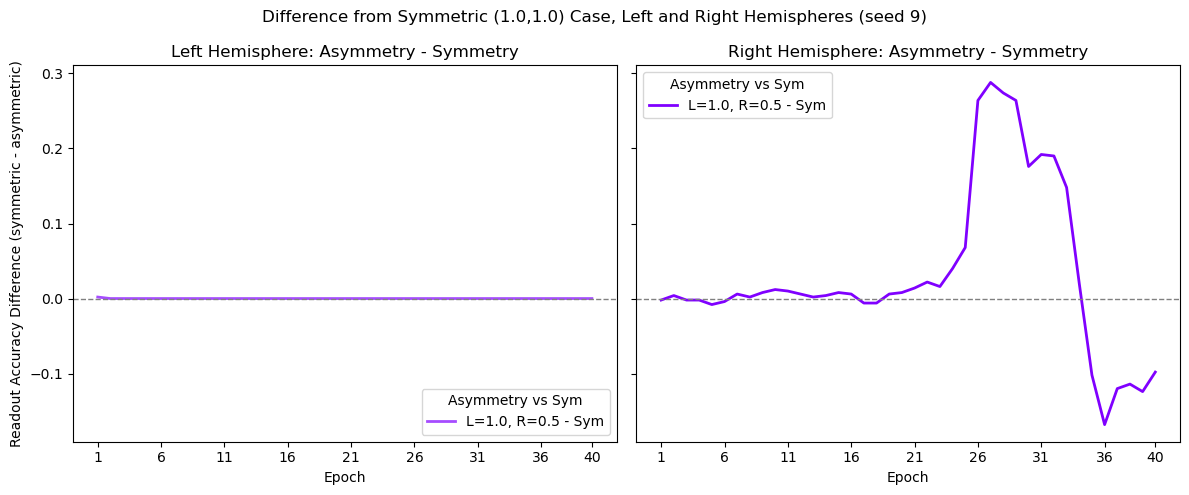

In [46]:
exp = DualALMRNNExp()
all_readout_acc_right = []
all_readout_acc_left = []
unfix_epochs = [0, 10, 20, 30, 40]

random_seed = 9
unfix_epochs = [1,11,21,40]
unfix_epoch = 1
asymmetries = [(1.0,0.5),(1.0,1.0)]

# For color mapping: use a colormap for right hemisphere lines

cmap = plt.get_cmap('Blues')
cmap = plt.get_cmap('rainbow')
colors = [cmap(i/(len(unfix_epochs)-1)) for i in range(len(unfix_epochs))]

# Iterate over asymmetries instead of unfix_epochs
all_readout_acc_right = []
all_readout_acc_left = []
asymmetry_labels = []
for i, (left_alm_amp, right_alm_amp) in enumerate(asymmetries):
    if 'asymmetric_fix' in exp.configs['train_type']:
        results_dict = np.load(
            'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/unfix_epoch_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
                exp.configs['model_type'],
                "train_type_asymmetric_fixed_input",
                # exp.configs['random_seed'],
                random_seed,
                unfix_epoch,
                left_alm_amp,
                right_alm_amp),
            allow_pickle=True
        )

    epochs = np.arange(1, len(results_dict) + 1)
    readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
    readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

    all_readout_acc_left.append(readout_acc_left)
    all_readout_acc_right.append(readout_acc_right)
    asymmetry_labels.append(f"L={left_alm_amp:.1f}, R={right_alm_amp:.1f}")

# Set xticks every 5 epochs (e.g., 1, 5, 10, 15, ...)
max_epoch = epochs[-1]
xticks = np.arange(1, max_epoch+1, 5)
if xticks[-1] != max_epoch:
    xticks = np.append(xticks, max_epoch)

# Find the index of the symmetric case (1.0, 1.0)
try:
    sym_idx = asymmetries.index((1.0, 1.0))
except ValueError:
    raise ValueError("Symmetric case (1.0, 1.0) not found in asymmetries list.")

# Compute differences: (other - symmetric) for left and right hemispheres
diff_left = []
diff_right = []
diff_labels = []
for i, (left_alm_amp, right_alm_amp) in enumerate(asymmetries):
    if i == sym_idx:
        continue  # skip symmetric case
    diff_left.append(all_readout_acc_left[i] - all_readout_acc_left[sym_idx])
    diff_right.append(all_readout_acc_right[i] - all_readout_acc_right[sym_idx])
    diff_labels.append(f"L={left_alm_amp:.1f}, R={right_alm_amp:.1f} - Sym")

# Plot: two subplots, left and right hemisphere accuracy difference (asym - sym)
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Left hemisphere difference subplot
for i, label in enumerate(diff_labels):
    ax_left.plot(epochs, diff_left[i], color=colors[i], label=label, alpha=0.7, linewidth=2)
ax_left.set_title('Left Hemisphere: Asymmetry - Symmetry')
ax_left.set_xlabel('Epoch')
ax_left.set_ylabel('Readout Accuracy Difference (symmetric - asymmetric)')
ax_left.set_xticks(xticks)
ax_left.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_left.legend(title='Asymmetry vs Sym', loc='lower right')

# Right hemisphere difference subplot
for i, label in enumerate(diff_labels):
    ax_right.plot(epochs, diff_right[i], color=colors[i], label=label, linewidth=2)
ax_right.set_title('Right Hemisphere: Asymmetry - Symmetry')
ax_right.set_xlabel('Epoch')
ax_right.set_xticks(xticks)
ax_right.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_right.legend(title='Asymmetry vs Sym', loc='upper left')

plt.suptitle('Difference from Symmetric (1.0,1.0) Case, Left and Right Hemispheres (seed {})'.format(random_seed))
plt.tight_layout()
plt.show()

Plot over all seeds:

Skipping seed 4 for asymmetry (1.0,0.0): [Errno 2] No such file or directory: 'dual_alm_rnn_logs/TwoHemiRNNTanh_single_readout/train_type_asymmetric_fixed_input/n_neurons_4_random_seed_4/unfix_epoch_1/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_0.00/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'
Skipping seed 5 for asymmetry (1.0,0.0): [Errno 2] No such file or directory: 'dual_alm_rnn_logs/TwoHemiRNNTanh_single_readout/train_type_asymmetric_fixed_input/n_neurons_4_random_seed_5/unfix_epoch_1/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_0.00/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'
Skipping seed 6 for asymmetry (1.0,0.0): [Errno 2] No such file or directory: 'dual_alm_rnn_logs/TwoHemiRNNTanh_single_readout/train_type_asymmetric_fixed_input/n_neurons_4_random_seed_6/unfix_epoch_1/n_epochs_

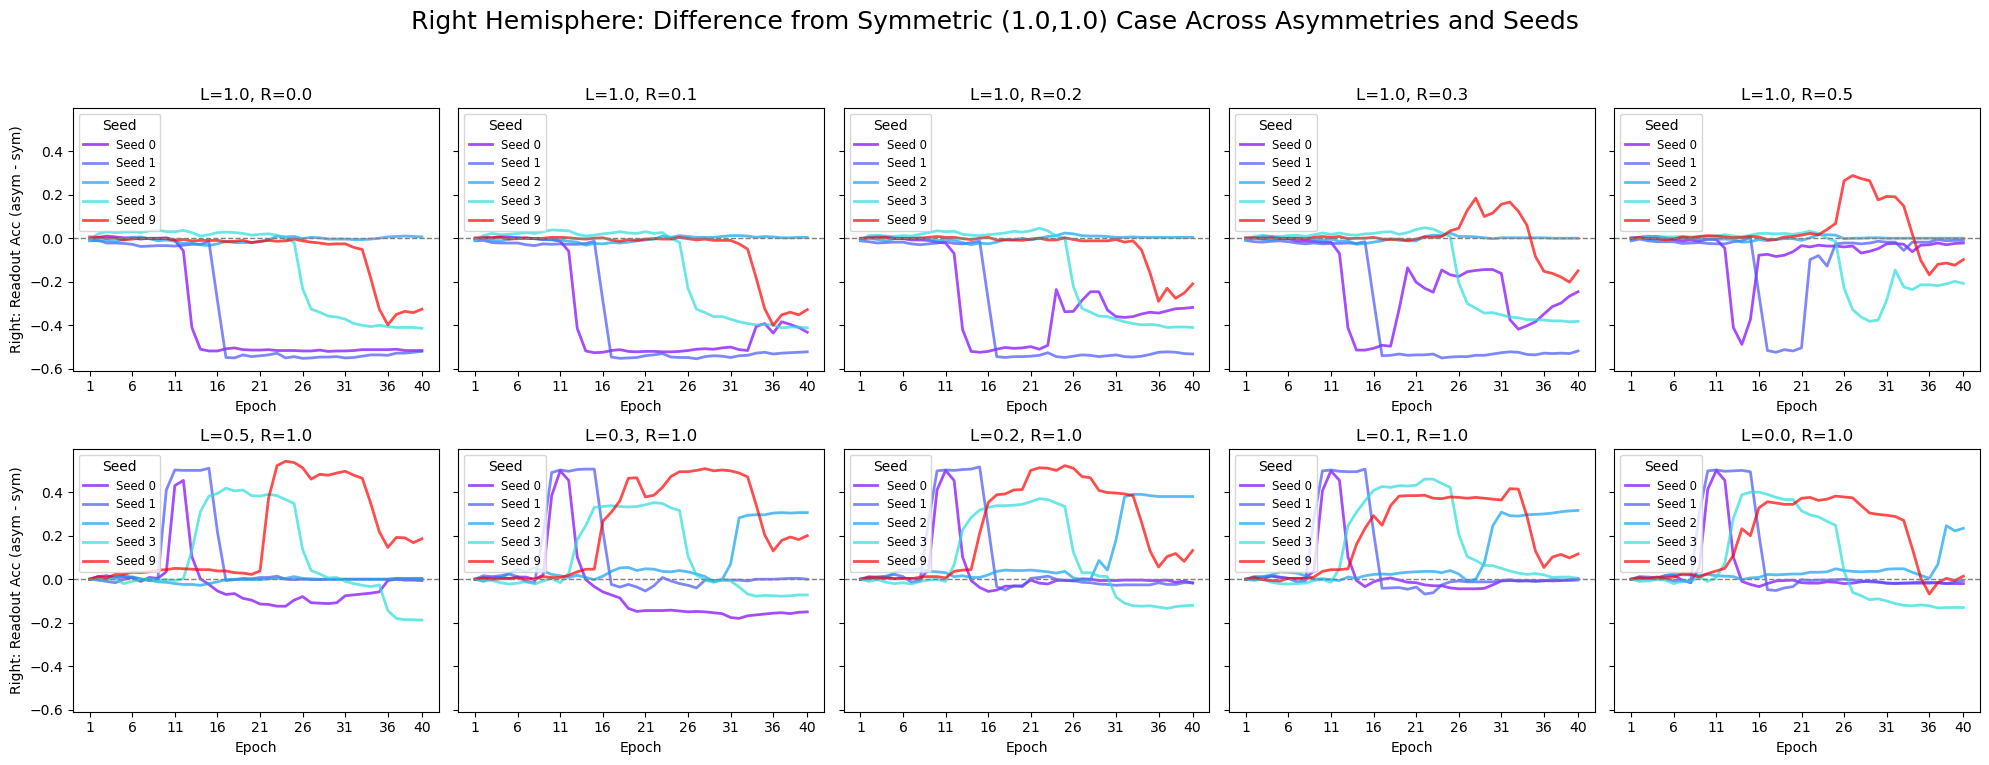

In [48]:
exp = DualALMRNNExp()
all_readout_acc_right = []
all_readout_acc_left = []
unfix_epochs = [0, 10, 20, 30, 40]

random_seed = 9
unfix_epochs = [1,11,21,40]
unfix_epoch = 1
asymmetries = [(1.0,0.5),(1.0,1.0)]

# For color mapping: use a colormap for right hemisphere lines

cmap = plt.get_cmap('Blues')
cmap = plt.get_cmap('rainbow')
colors = [cmap(i/(len(unfix_epochs)-1)) for i in range(len(unfix_epochs))]

# Plot right hemisphere readout accuracy differences (asym - sym) for 10 asymmetries, each in its own subplot (2 rows x 5 columns), across 10 seeds

# Settings
# Define 10 asymmetries (excluding the symmetric case)
asymmetries = [
    (1.0, 0.0), (1.0, 0.1), (1.0, 0.2), (1.0, 0.3), (1.0, 0.5),
    (0.5, 1.0), (0.3, 1.0), (0.2, 1.0), (0.1, 1.0), (0.0, 1.0), 
]
symmetric = (1.0, 1.0)
seeds = list(range(10))
unfix_epoch = 1
model_type = exp.configs['model_type']
train_type = "train_type_asymmetric_fixed_input"

# For color mapping: use a colormap for seeds
cmap = plt.get_cmap('rainbow')
colors = [cmap(i/(len(seeds)-1)) for i in range(len(seeds))]

# Preload all symmetric results for all seeds
sym_results = {}
for seed in seeds:
    try:
        results_sym = np.load(
            f'dual_alm_rnn_logs/{model_type}/{train_type}/n_neurons_4_random_seed_{seed}/unfix_epoch_{unfix_epoch}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{symmetric[0]:.2f}_right_alm_amp_{symmetric[1]:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy',
            allow_pickle=True
        )
        sym_results[seed] = results_sym
    except Exception as e:
        print(f"Skipping symmetric seed {seed}: {e}")

# Prepare subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
axes = axes.flatten()

for asym_idx, (left_alm_amp, right_alm_amp) in enumerate(asymmetries):
    ax = axes[asym_idx]
    diff_right_seeds = []
    epochs = None

    for seed_idx, seed in enumerate(seeds):
        # Load asymmetric results
        try:
            results_asym = np.load(
                f'dual_alm_rnn_logs/{model_type}/{train_type}/n_neurons_4_random_seed_{seed}/unfix_epoch_{unfix_epoch}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{left_alm_amp:.2f}_right_alm_amp_{right_alm_amp:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy',
                allow_pickle=True
            )
            results_sym = sym_results.get(seed, None)
            if results_sym is None:
                continue
        except Exception as e:
            print(f"Skipping seed {seed} for asymmetry ({left_alm_amp},{right_alm_amp}): {e}")
            continue

        # Get epochs
        if epochs is None:
            epochs = np.arange(1, min(len(results_asym), len(results_sym)) + 1)
        n_epochs = len(epochs)

        # Get right hemisphere readout accuracies
        readout_acc_right_asym = np.array([results_asym[i]['control']['readout_accuracy_right'] for i in range(n_epochs)])
        readout_acc_right_sym = np.array([results_sym[i]['control']['readout_accuracy_right'] for i in range(n_epochs)])

        diff = readout_acc_right_asym - readout_acc_right_sym
        diff_right_seeds.append(diff)
        ax.plot(epochs, diff, color=colors[seed_idx], alpha=0.7, linewidth=2, label=f"Seed {seed}")

    # Format subplot
    ax.set_title(f"L={left_alm_amp:.1f}, R={right_alm_amp:.1f}")
    ax.set_xlabel('Epoch')
    if asym_idx % 5 == 0:
        ax.set_ylabel('Right: Readout Acc (asym - sym)')
    xticks = np.arange(1, epochs[-1]+1, 5) if epochs is not None else []
    if len(xticks) and xticks[-1] != epochs[-1]:
        xticks = np.append(xticks, epochs[-1])
    if len(xticks):
        ax.set_xticks(xticks)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    if len(diff_right_seeds) <= 10:
        ax.legend(title='Seed', loc='upper left', fontsize='small')

plt.suptitle('Right Hemisphere: Difference from Symmetric (1.0,1.0) Case Across Asymmetries and Seeds', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Get the model


In [6]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)

model = getattr(sys.modules[__name__], configs['model_type'])(configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(configs['train_type'])

checkpoint_file = 'model_epoch_9.pth'
checkpoint_path = os.path.join(configs['models_dir'], configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
# params = {'batch_size': configs['bs'], 'shuffle': True}
# inputs = data.TensorDataset(torch.tensor(sensory_inputs), torch.tensor(trial_type_labels))
# inputs = data.DataLoader(inputs, **params)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)

# Draw the readout trajectory
bias = model.readout_linear.bias.data.cpu().numpy()[0]
readout_weights = model.readout_linear.weight.data.cpu().numpy()
recurrent_weights = model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy()


# model.rnn_cell.w_hh_linear_ll.weight.data = torch.tensor([
#     [1.5, -0.3],
#     [-0.3, 1.5]], dtype=torch.float32).to(device)
# model.rnn_cell.w_hh_linear_ll.bias.data = torch.tensor([0.0, 0.0], dtype=torch.float32).to(device)
# model.w_xh_linear_left_alm.weight.data = torch.tensor([
#     [1.0, 0.0],
#     [0.0, 1.0]
# ], dtype=torch.float32).to(device)

# model.readout_linear.weight.data = torch.tensor([
#     [1.0, -1.0, 0.0, 0.0]
# ], dtype=torch.float32).to(device)
# model.w_xh_linear_left_alm.bias.data = torch.tensor([0.0, 0.0], dtype=torch.float32).to(device)
# print(bias, readout_weights, recurrent_weights)


Fixed input weights for left and right ALM
dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_asymmetric_fixed_input/n_neurons_4_random_seed_4/unfix_epoch_10/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/model_epoch_9.pth
